In [1]:
# In this notebook we plot the error (both ELPP and MSE) of GPC as a function of number of training data points

In [2]:
import logging
import time

import pyDOE
import matplotlib.pyplot as plt
import numpy as np
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

from src.models.bfgpc import BFGPC_ELBO

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [3]:
N_reps = 10

def train_eval_gpc(N_train):
    elpps = []
    mses = []
    for _ in range(N_reps):
        X_train = pyDOE.lhs(2, N_train)
        Y_train = sample_HF_outcomes(X_train)

        kernel = 1.0 * RBF(length_scale=1.0)
        model = GaussianProcessClassifier(kernel=kernel)
        model.fit(X_train, Y_train)

        # ELPP
        probas = model.predict_proba(X_test)
        num_test_samples = len(Y_test)
        correct_class_probas = probas[np.arange(num_test_samples), Y_test]
        log_predictive_probas = np.log(correct_class_probas)
        elpp = np.mean(log_predictive_probas)

        # MSE of probs
        mse = np.mean((probas[np.arange(num_test_samples), 1] - p_test_true)**2)

        elpps.append(elpp)
        mses.append(mse)

    return {'elpp': np.mean(elpps), 'mse': np.mean(mses)}

def train_eval_bfgpc(N_train_LF, N_train_HF):
    elpps = []
    mses = []
    for _ in range(N_reps):
        X_train_LF = pyDOE.lhs(2, N_train_LF)
        X_train_HF = pyDOE.lhs(2, N_train_HF)
        Y_train_LF = sample_LF_outcomes(X_train_LF)
        Y_train_HF = sample_HF_outcomes(X_train_HF)

        model = BFGPC_ELBO(n_inducing_pts=N_train_HF // 2)
        model.train_model(X_train_LF, Y_train_LF, X_train_HF, Y_train_HF, n_epochs=N_train_HF, lr=0.1)

        # ELPP
        elpp = model.evaluate_elpp(X_test, Y_test)

        # MSE
        probs = model.predict_hf_prob(X_test)
        mse = np.mean((probs - p_test_true)**2)

        elpps.append(elpp)
        mses.append(mse)

    return {'elpp': np.mean(elpps), 'mse': np.mean(mses)}





In [4]:
def run_experiment(X_test, Y_test, p_test_true):
    # We fix the number of low-fidelity points for the BFGPC to a large value
    # and compare convergence against a standard GPC as N_H increases.

    print("\n--- Starting GPC vs. BFGPC Convergence Comparison ---")

    N_H_comparison_vals = np.array([5, 10, 20, 50, 100, 150, 200, 300, 400, 500])
    N_L_fixed = 1000  # A large, fixed number of LF points for the BFGPC

    # Lists to store results
    gpc_results = []
    bfgpc_results = []

    for n_h in N_H_comparison_vals:
        # Train and evaluate the single-fidelity GPC
        print(f"Running GPC with N_H={n_h}...")
        start_time = time.time()
        gpc_res = train_eval_gpc(n_h)
        gpc_results.append(gpc_res)
        end_time = time.time()
        print(f"Finished in {end_time - start_time:.2f}s. RMSE: {np.sqrt(gpc_res['mse']):.4f}, ELPP: {gpc_res['elpp']:.4f}")

        # Train and evaluate the bi-fidelity BFGPC
        print(f"Running BFGPC with N_L={n_h}, N_H={n_h}...")
        start_time = time.time()
        bfgpc_res = train_eval_bfgpc(min(1000, 4 * n_h), n_h)
        bfgpc_results.append(bfgpc_res)
        end_time = time.time()
        print(
            f"Finished in {end_time - start_time:.2f}s. RMSE: {np.sqrt(bfgpc_res['mse']):.4f}, ELPP: {bfgpc_res['elpp']:.4f}")

    # Convert results to numpy arrays for easier plotting
    gpc_rmses = np.array([np.sqrt(r['mse']) for r in gpc_results])
    gpc_elpps = np.array([r['elpp'] for r in gpc_results])

    bfgpc_rmses = np.array([np.sqrt(r['mse']) for r in bfgpc_results])
    bfgpc_elpps = np.array([r['elpp'] for r in bfgpc_results])

    print("\n--- GPC vs. BFGPC Comparison Finished ---")

    # Plotting the comparison results

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3), dpi=200, sharex=True)
    fig.suptitle('GPC (HF only) vs. BFGPC Convergence', fontsize=16)

    # Plot RMSE comparison
    ax1.plot(N_H_comparison_vals, gpc_rmses, 'o-', label='GPC (HF only)')
    ax1.plot(N_H_comparison_vals, bfgpc_rmses, 's-', label=f'BFGPC ($N_L$={N_L_fixed})')
    ax1.set_xlabel('Number of High-Fidelity Points ($N_H$)')
    ax1.set_ylabel('RMSE of $P(Y_{HF}=1)$')
    ax1.set_xscale('log')
    ax1.grid(True, which="both", ls="--")
    ax1.legend()

    # Plot ELPP comparison
    ax2.plot(N_H_comparison_vals, gpc_elpps, 'o-', label='GPC (HF only)')
    ax2.plot(N_H_comparison_vals, bfgpc_elpps, 's-', label=f'BFGPC ($N_L$={N_L_fixed})')
    ax2.set_xlabel('Number of High-Fidelity Points ($N_H$)')
    ax2.set_ylabel('ELPP (higher is better)')
    ax2.grid(True, which="both", ls="--")
    ax2.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [ ]:
from src.problems.psaap_example import get_HF_probs, get_LF_probs, sample_HF_outcomes, sample_LF_outcomes

X_test = pyDOE.lhs(2, samples=10_000)
Y_test = sample_HF_outcomes(X_test)
p_test_true = get_HF_probs(X_test)
run_experiment(X_test, Y_test, p_test_true)


--- Starting GPC vs. BFGPC Convergence Comparison ---
Running GPC with N_H=5...
Finished in 0.06s. RMSE: 0.3799, ELPP: -0.6552
Running BFGPC with N_L=5, N_H=5...


/Users/murray/miniconda3/envs/mfal/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/murray/miniconda3/envs/mfal/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Finished in 13.29s. RMSE: 0.3942, ELPP: -0.6817
Running GPC with N_H=10...
Finished in 0.07s. RMSE: 0.2777, ELPP: -0.5068
Running BFGPC with N_L=10, N_H=10...


/Users/murray/miniconda3/envs/mfal/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/murray/miniconda3/envs/mfal/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Finished in 14.56s. RMSE: 0.2628, ELPP: -0.4874
Running GPC with N_H=20...
Finished in 0.08s. RMSE: 0.1731, ELPP: -0.3915
Running BFGPC with N_L=20, N_H=20...
Finished in 16.15s. RMSE: 0.1476, ELPP: -0.3607
Running GPC with N_H=50...
Finished in 0.13s. RMSE: 0.1456, ELPP: -0.3609
Running BFGPC with N_L=50, N_H=50...
Finished in 21.65s. RMSE: 0.1316, ELPP: -0.3473
Running GPC with N_H=100...
Finished in 0.23s. RMSE: 0.1127, ELPP: -0.3278
Running BFGPC with N_L=100, N_H=100...
Finished in 32.18s. RMSE: 0.1196, ELPP: -0.3300
Running GPC with N_H=150...
Finished in 0.36s. RMSE: 0.1094, ELPP: -0.3294
Running BFGPC with N_L=150, N_H=150...
Finished in 51.40s. RMSE: 0.1077, ELPP: -0.3220
Running GPC with N_H=200...
Finished in 0.51s. RMSE: 0.1103, ELPP: -0.3246
Running BFGPC with N_L=200, N_H=200...
Finished in 75.23s. RMSE: 0.1081, ELPP: -0.3203
Running GPC with N_H=300...
Finished in 1.00s. RMSE: 0.0913, ELPP: -0.3125
Running BFGPC with N_L=300, N_H=300...
Finished in 150.28s. RMSE: 0.0751,

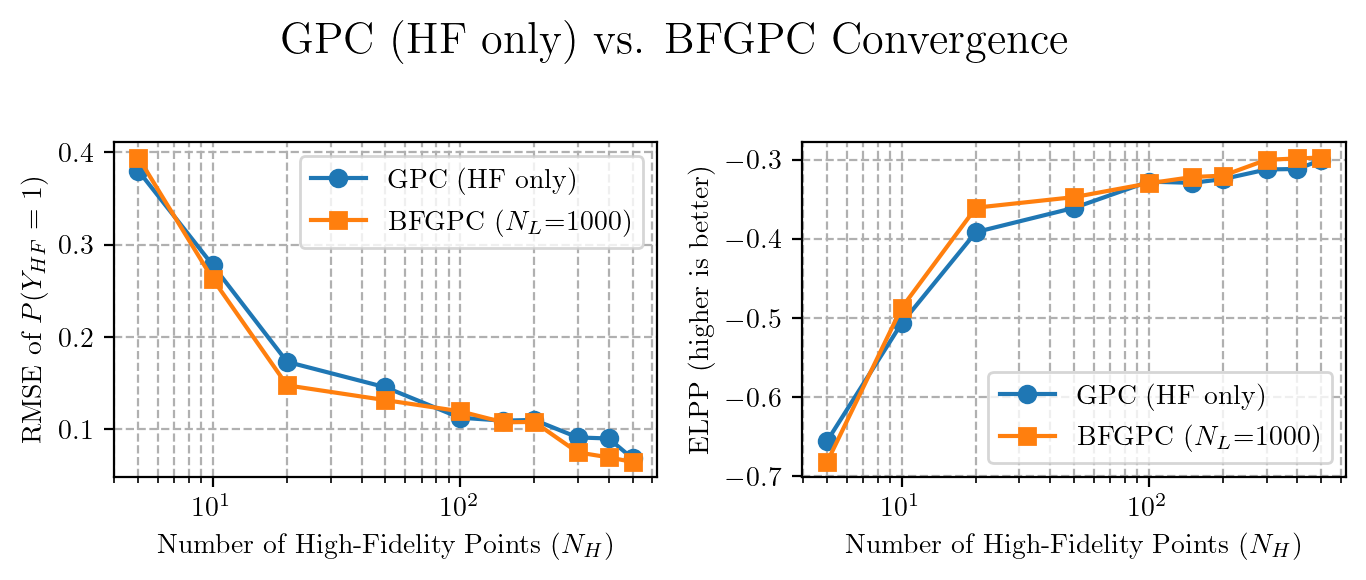

In [9]:
from src.problems.toy_example import create_smooth_change_nonlinear

get_LF_probs, get_HF_probs, _, _ = create_smooth_change_nonlinear()

def sample_HF_outcomes(X_normalized):
    Y_linear_high_grid, probs_linear_high_grid = get_HF_probs(X_normalized, reps=1)
    Y_linear_high_grid = Y_linear_high_grid.mean(axis=0).astype(int)
    return Y_linear_high_grid

def sample_LF_outcomes(X_normalized):
    Y_linear_low_grid, probs_linear_low_grid = get_LF_probs(X_normalized, reps=1)
    Y_linear_low_grid = Y_linear_low_grid.mean(axis=0).astype(int)
    return Y_linear_low_grid

X_test = pyDOE.lhs(2, samples=10_000)
Y_test = sample_HF_outcomes(X_test)
_, p_test_true = get_HF_probs(X_test)
run_experiment(X_test, Y_test, p_test_true)


--- Starting GPC vs. BFGPC Convergence Comparison ---
Running GPC with N_H=5...
Finished in 0.06s. RMSE: 0.3498, ELPP: -0.6084
Running BFGPC with N_L=5, N_H=5...
Finished in 14.10s. RMSE: 0.3537, ELPP: -0.6168
Running GPC with N_H=10...
Finished in 0.07s. RMSE: 0.2430, ELPP: -0.4632
Running BFGPC with N_L=10, N_H=10...
Finished in 14.62s. RMSE: 0.2461, ELPP: -0.4512
Running GPC with N_H=20...
Finished in 0.08s. RMSE: 0.1858, ELPP: -0.3983
Running BFGPC with N_L=20, N_H=20...
Finished in 16.64s. RMSE: 0.1571, ELPP: -0.3650
Running GPC with N_H=50...
Finished in 0.12s. RMSE: 0.1346, ELPP: -0.3461
Running BFGPC with N_L=50, N_H=50...
Finished in 21.80s. RMSE: 0.0993, ELPP: -0.3189
Running GPC with N_H=100...
Finished in 0.23s. RMSE: 0.0800, ELPP: -0.3084
Running BFGPC with N_L=100, N_H=100...
Finished in 32.57s. RMSE: 0.0769, ELPP: -0.3077
Running GPC with N_H=150...
Finished in 0.34s. RMSE: 0.0719, ELPP: -0.3021
Running BFGPC with N_L=150, N_H=150...
Finished in 51.30s. RMSE: 0.0666, EL

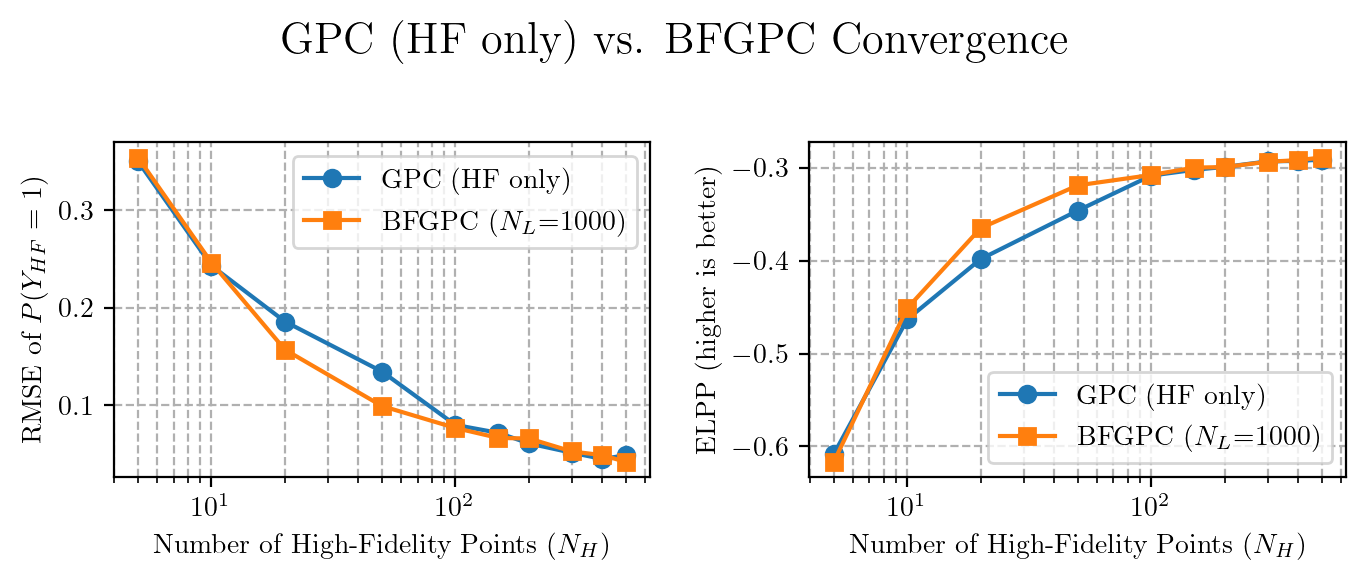

In [7]:
from src.problems.toy_example import create_smooth_change_linear

get_LF_probs, get_HF_probs, _, _ = create_smooth_change_linear()

def sample_HF_outcomes(X_normalized):
    Y_linear_high_grid, probs_linear_high_grid = get_HF_probs(X_normalized, reps=1)
    Y_linear_high_grid = Y_linear_high_grid.mean(axis=0).astype(int)
    return Y_linear_high_grid

def sample_LF_outcomes(X_normalized):
    Y_linear_low_grid, probs_linear_low_grid = get_LF_probs(X_normalized, reps=1)
    Y_linear_low_grid = Y_linear_low_grid.mean(axis=0).astype(int)
    return Y_linear_low_grid

X_test = pyDOE.lhs(2, samples=10_000)
Y_test = sample_HF_outcomes(X_test)
_, p_test_true = get_HF_probs(X_test)
run_experiment(X_test, Y_test, p_test_true)
